In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from brian2 import *
import librosa
import glob
import soundfile as sf
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from brian2 import prefs

prefs.codegen.target = 'cython'

try:
    import IPython.display as ipd
    from IPython.display import display
    in_notebook = True
except ImportError:
    in_notebook = False

num_samples = 1000
num_samples_partial = 3  # Число примеров, для которых мониторим детальную активность

tau = 10*ms
dt = 1*ms
defaultclock.dt = dt

eta = 1e-6 * Hz  
decay = 4e-3
sample_duration = 100*ms
num_time_steps_per_sample = int(sample_duration / dt)
total_duration = num_samples * sample_duration

N_hidden = 300

def load_full_mnist():
    """
    Загрузка полной выборки MNIST (784 входных признака + класс метки [0..9]).
    Нормировка входных пикселей к диапазону [0, 1].
    """
    df = pd.read_csv('mnist_784.csv')
    X = df.iloc[:, 0:784].values / 255.0
    y = df.iloc[:, 784].values  
    return X, y

def load_preprocess_audio(num_samples, target_length=5000):
    """
    Загрузка аудиофайлов, удаление тишины с помощью extract_useful_signal,
    нормировка их в диапазон [0, 1], 
    выравнивание длины до target_length путём усечения или дополнения нулями.
    """
    audio_files = glob.glob('free-spoken-digit-dataset/recordings/*.wav')
    np.random.shuffle(audio_files)
    selected_files = audio_files[:num_samples]
    
    X_audio_list = []
    sr_list = []
    digits_audio = []

    for file in selected_files:
        base_name = file.split('/')[-1]
        digit_str = base_name.split('_')[0]
        audio_digit = int(digit_str)
        digits_audio.append(audio_digit)
         
        signal, sr = librosa.load(file, sr=None)
        # Удаляем тишину слева и справа
        extract = librosa.effects.trim(signal, top_db=20)           
        sr_list.append(sr)

        # Усечение или дополнение до target_length
        if len(extract) > target_length:
            signal = extract[:target_length]
        else:
            signal = np.pad(extract, (0, target_length - len(extract)), 'constant')
        
        # Масштабируем сигнал в диапазон [0, 1]
        min_val, max_val = np.min(signal), np.max(signal)
        # Во избежание деления на 0 добавляем небольшую константу
        if max_val - min_val < 1e-12:
            signal = np.zeros_like(signal)  # если сигнал фактически нулевой
        else:
            signal = (signal - min_val) / (max_val - min_val)
        
        X_audio_list.append(signal)
    
    X_audio = np.array(X_audio_list)
    sr = sr_list[0] if sr_list else 22050

    unique_digits = np.unique(digits_audio)
    if len(unique_digits) < 2 and num_samples > 1:
        raise ValueError("Недостаточно разнообразных классов. Увеличьте количество файлов или перезапустите.")

    return X_audio, sr, digits_audio

def match_images_to_audio_digits(X, y, digits_audio, num_samples):
    """
    Для каждой аудиозаписи выбираем случайное изображение с той же цифрой (в MNIST).
    Возвращаем матрицу изображений с такой же длиной, что и X_audio.
    """
    matched_images = []
    for d in digits_audio:
        indices = np.where(y == d)[0]
        if len(indices) == 0:
            raise ValueError(f"Не найдено изображений в MNIST с цифрой {d}")
        idx = np.random.choice(indices)
        matched_images.append(X[idx])
    matched_images = np.array(matched_images)
    return matched_images

def prepare_input_data(X_image, X_audio, num_time_steps_per_sample):
    """
    Формируем массивы признаков (признаки изображений и аудио) 
    во временном формате для подачи в TimedArray (Brian2).
    """
    num_samples_local = X_image.shape[0]
    N_input_image = X_image.shape[1]
    N_input_audio = X_audio.shape[1]
    
    total_time_steps = num_samples_local * num_time_steps_per_sample
    input_image_array = np.zeros((total_time_steps, N_input_image))
    input_audio_array = np.zeros((total_time_steps, N_input_audio))
    
    for i in range(num_samples_local):
        start_idx = i * num_time_steps_per_sample
        end_idx = (i + 1) * num_time_steps_per_sample
        input_image_array[start_idx:end_idx, :] = X_image[i]
        input_audio_array[start_idx:end_idx, :] = X_audio[i]

    print(input_image_array.shape)
    print(input_audio_array.shape)
    Image_ext = TimedArray(input_image_array, dt=dt)
    Audio_ext = TimedArray(input_audio_array, dt=dt)
    
    return Image_ext, Audio_ext
    
X_full, y_full = load_full_mnist()
X_audio, sr, digits_audio = load_preprocess_audio(num_samples=num_samples, target_length=5000)
X_image = match_images_to_audio_digits(X_full, y_full, digits_audio, num_samples=num_samples)
Image_ext, Audio_ext = prepare_input_data(X_image, X_audio, num_time_steps_per_sample)

N_input_image = 784
N_input_audio = X_audio.shape[1]

print("Кол-во нейронов для аудио", N_input_audio)
print("Размерность аудио-признаков:", X_audio.shape)
print("Пример меток (цифры из аудио):", digits_audio[:10])
print("Размерность набора изображений:", X_image.shape)

INFO       Cache size for target 'cython': 1513 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/buligar/.cython/brian_extensions' directory. [brian2]


In [3]:
start_scope()

w_input_image_hidden_init = np.random.randn(N_input_image * N_hidden)*0.01
w_input_audio_hidden_init = np.random.randn(N_input_audio * N_hidden)*0.01
w_hidden_image_input_init = np.random.randn(N_hidden * N_input_image)*0.01
w_hidden_audio_input_init = np.random.randn(N_hidden * N_input_audio)*0.01

threshold_value = 'v > 0.5'
threshold_value_3 = 'v > 0.3'

input_image_neurons = NeuronGroup(N_input_image, '''
    dv/dt = (-v + V_error) / tau : 1
    V_error = Image_ext(t, i) - v + V_feedback : 1
    V_feedback : 1
    ''',
    threshold=threshold_value, reset='v = 0', method='euler')

input_audio_neurons = NeuronGroup(N_input_audio, '''
    dv/dt = (-v + V_error) / tau : 1
    V_error = Audio_ext(t, i) - v + V_feedback : 1
    V_feedback : 1
    ''',
    threshold=threshold_value, reset='v = 0', method='euler')

hidden_neurons = NeuronGroup(N_hidden, '''
    dv/dt = (-v + V_input_image + V_input_audio) / tau : 1
    V_input_image : 1
    V_input_audio : 1
    ''',
    threshold=threshold_value_3, reset='v = 0', method='euler')

syn_input_image_hidden = Synapses(input_image_neurons, hidden_neurons, '''
    V_input_image_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_input_image_hidden.connect()
syn_input_image_hidden.w = w_input_image_hidden_init 

syn_input_audio_hidden = Synapses(input_audio_neurons, hidden_neurons, '''
    V_input_audio_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_input_audio_hidden.connect()
syn_input_audio_hidden.w = w_input_audio_hidden_init

syn_hidden_image_input = Synapses(hidden_neurons, input_image_neurons, '''
    V_feedback_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_hidden_image_input.connect()
syn_hidden_image_input.w = w_hidden_image_input_init

syn_hidden_audio_input = Synapses(hidden_neurons, input_audio_neurons, '''
    V_feedback_post = w * v_pre : 1 (summed)
    dw/dt = eta * (v_post * v_pre - w * decay) : 1 (clock-driven)
    ''')
syn_hidden_audio_input.connect()
syn_hidden_audio_input.w = w_hidden_audio_input_init

partial_duration = num_samples_partial * sample_duration
remaining_duration = total_duration - partial_duration

mon_hidden = StateMonitor(hidden_neurons, 'v', record=True)
mon_input_image = StateMonitor(input_image_neurons, 'v', record=True)
mon_input_audio = StateMonitor(input_audio_neurons, 'v', record=True)
spikes_input_image = SpikeMonitor(input_image_neurons)
spikes_input_audio = SpikeMonitor(input_audio_neurons)
spikes_hidden = SpikeMonitor(hidden_neurons)

In [4]:
print("Выполнение симуляции для первых 3 примеров...")
run(partial_duration)

mon_input_image.active = False
mon_input_audio.active = False
spikes_input_image.active = False
spikes_input_audio.active = False
spikes_hidden.active = False

Выполнение симуляции для первых 3 примеров...


INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'synapses_2', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'synapses_3', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'synapses_3', but also exists in the run namesp


Анимационная реконструкция для образца изображения 0, цифра: 4



Анимационная реконструкция для аудиосэмпла 0, цифра: 4


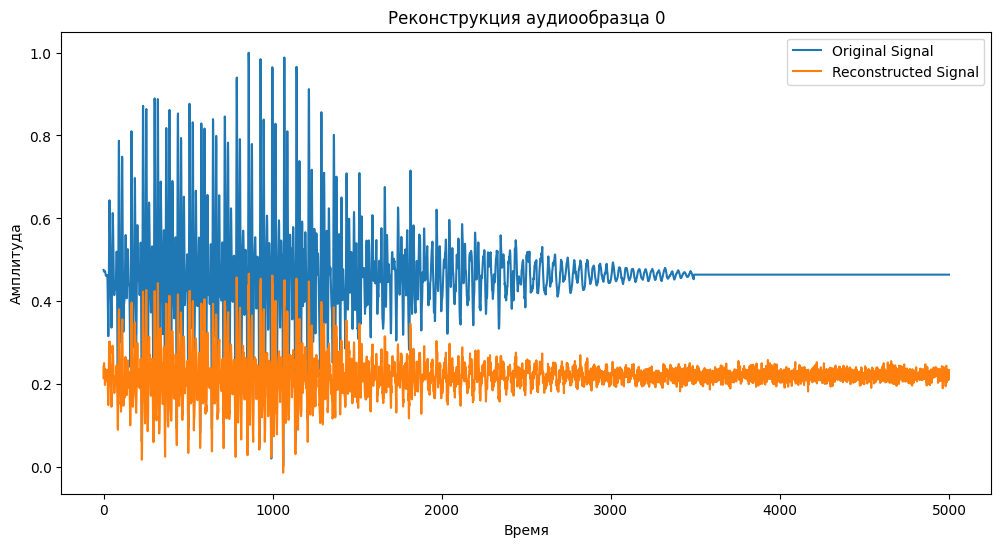

Оригинальный сигнал:


Реконструированный сигнал:



Анимационная реконструкция для образца изображения 1, цифра: 0



Анимационная реконструкция для аудиосэмпла 1, цифра: 0


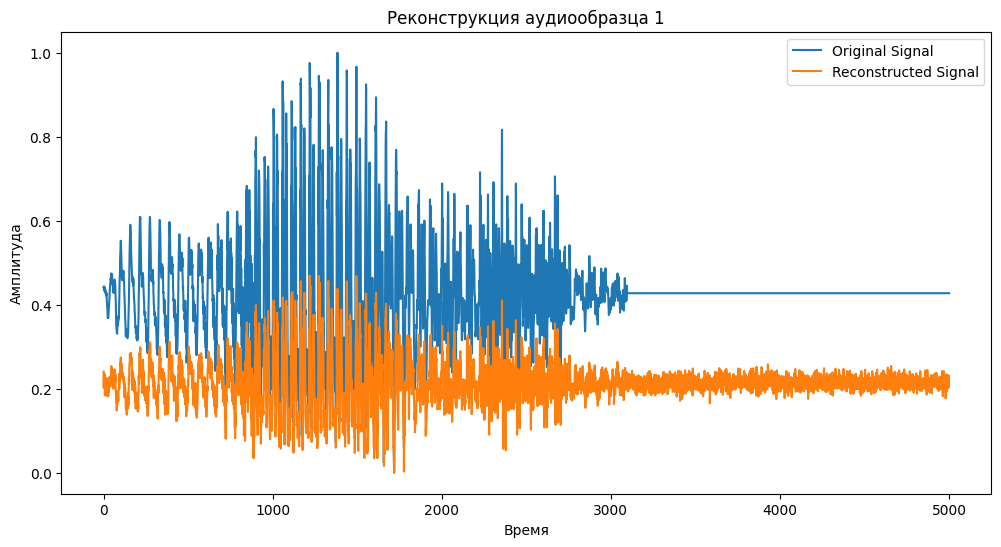

Оригинальный сигнал:


Реконструированный сигнал:



Анимационная реконструкция для образца изображения 2, цифра: 8



Анимационная реконструкция для аудиосэмпла 2, цифра: 8


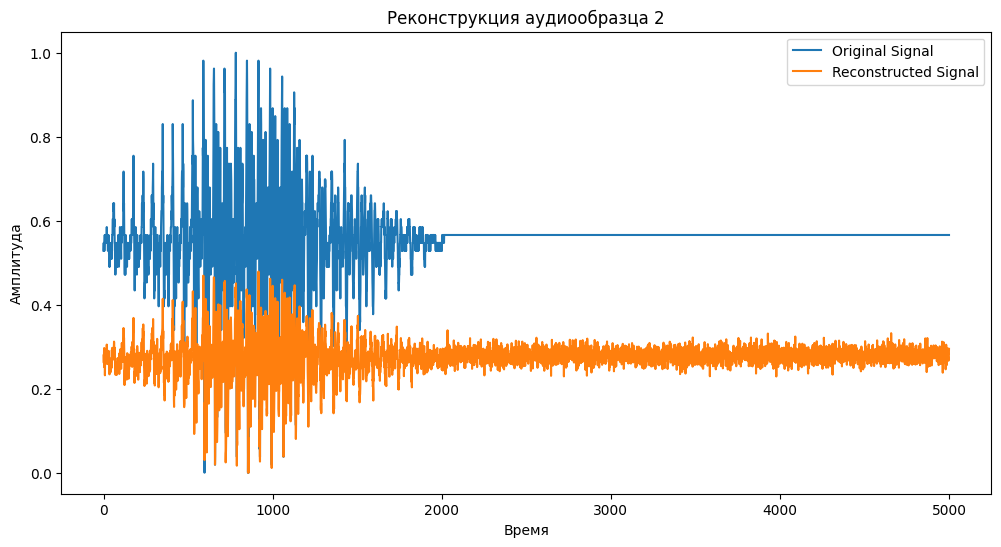

Оригинальный сигнал:


Реконструированный сигнал:


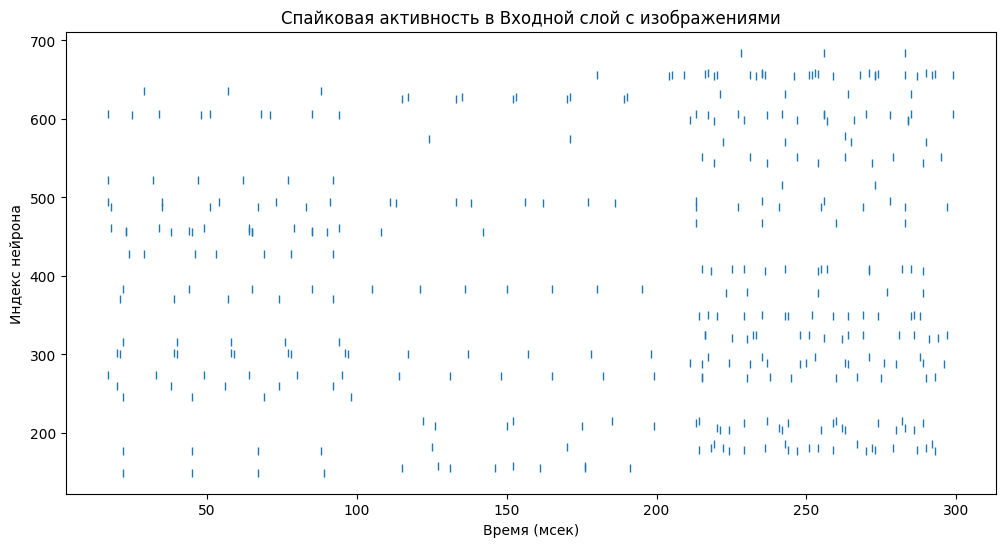

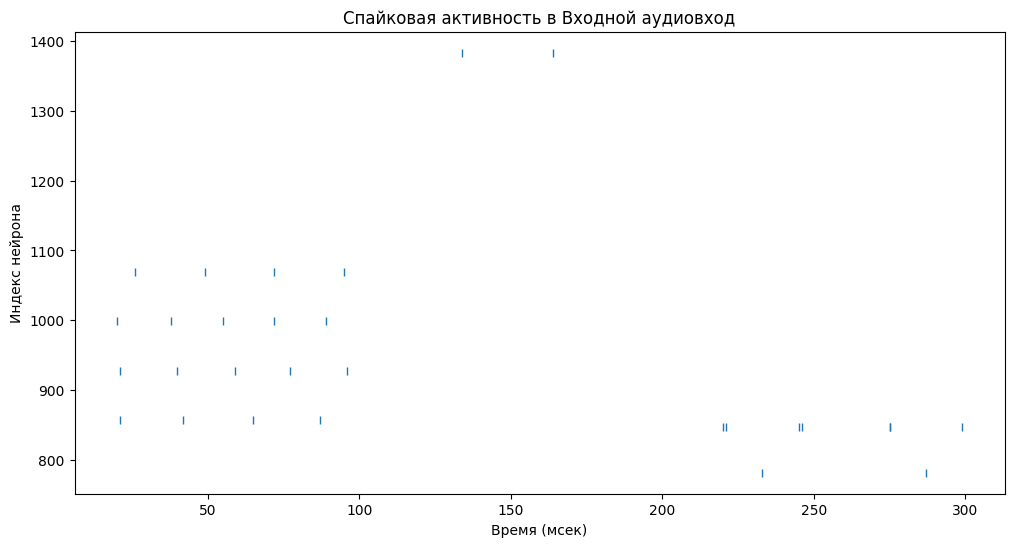

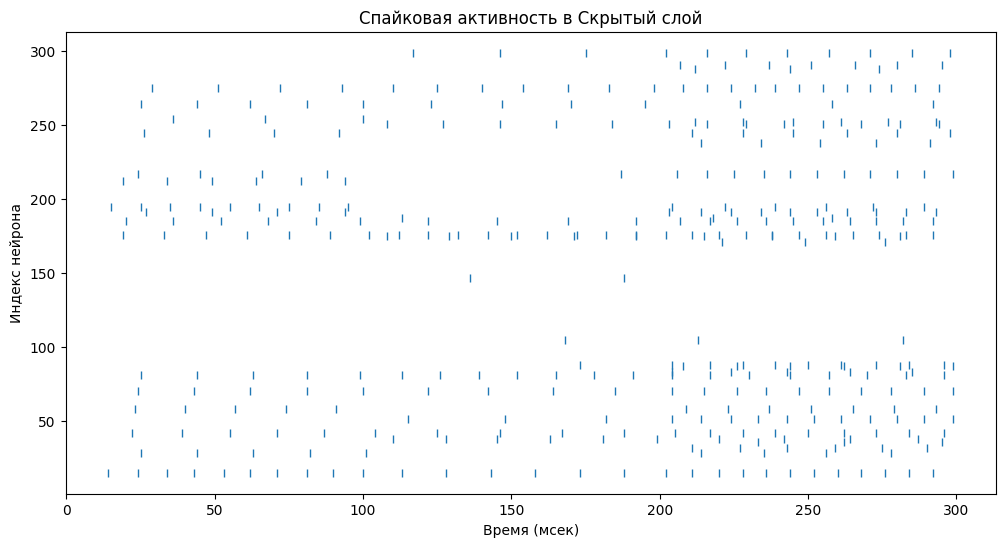

In [5]:
def animate_reconstruction_image(sample_index):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    
    fig = plt.figure()
    plt.axis('off')
    ims = []
    
    for t in range(start_idx, end_idx):
        reconstructed_img = mon_input_image.v[:, t]
        im = plt.imshow(reconstructed_img.reshape(28,28), cmap='gray', animated=True)
        ims.append([im])
    
    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
    ani.save(f'animation_sample{sample_index}.gif')
    plt.title(f'Реконструкция образца изображения {sample_index} по времени')
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

def animate_reconstruction_audio(sample_index, audio = True, xlim = None):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    
    reconstructed_signal = mon_input_audio.v[:, start_idx:end_idx].mean(axis=1)
    original_signal = X_audio[sample_index]
    
    
    plt.figure(figsize=(12, 6))
    plt.plot(original_signal, label='Original Signal')
    plt.plot(reconstructed_signal, label='Reconstructed Signal')
    plt.legend()
    plt.title(f'Реконструкция аудиообразца {sample_index}')
    plt.xlabel('Время')
    plt.ylabel('Амплитуда')
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    plt.show()
    if audio:
        sf.write(f'original_signal_sample{sample_index}.wav', original_signal, sr)
        sf.write(f'reconstructed_signal_sample{sample_index}.wav', reconstructed_signal, sr)
    
    if in_notebook:
        print("Оригинальный сигнал:")
        display(ipd.Audio(original_signal, rate=sr))
        print("Реконструированный сигнал:")
        display(ipd.Audio(reconstructed_signal, rate=sr))

def plot_spikes(spike_monitor, layer_name):
    plt.figure(figsize=(12, 6))
    plt.plot(spike_monitor.t/ms, spike_monitor.i, '|')
    plt.title(f'Спайковая активность в {layer_name}')
    plt.xlabel('Время (мсек)')
    plt.ylabel('Индекс нейрона')
    plt.show()

for idx in range(num_samples_partial):
    print(f'\nАнимационная реконструкция для образца изображения {idx}, цифра: {digits_audio[idx]}')
    animate_reconstruction_image(idx)
    print(f'\nАнимационная реконструкция для аудиосэмпла {idx}, цифра: {digits_audio[idx]}')
    animate_reconstruction_audio(idx, [500, 600])

plot_spikes(spikes_input_image, 'Входной слой с изображениями')
plot_spikes(spikes_input_audio, 'Входной аудиовход')
plot_spikes(spikes_hidden, 'Скрытый слой')

In [6]:
print("Выполнение симуляции для оставшихся примеров...")
run(remaining_duration)

hidden_data_all = mon_hidden.v[:,:]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2)
clf_classic = LogisticRegression(max_iter=1000)
clf_classic.fit(X_train_full, y_train_full)
y_pred_classic = clf_classic.predict(X_test_full)
classic_accuracy = accuracy_score(y_test_full, y_pred_classic)

hidden_activity = []
for idx in range(num_samples):
    start_idx = idx * num_time_steps_per_sample
    end_idx = (idx + 1) * num_time_steps_per_sample
    mean_activity = np.mean(mon_hidden.v[:, start_idx:end_idx], axis=1)
    hidden_activity.append(mean_activity)

hidden_activity = np.array(hidden_activity)
y_labels = np.array(digits_audio)

print("Размер данных до очистки:", hidden_activity.shape, len(y_labels))
print("Проверка NaN в hidden_activity:", np.isnan(hidden_activity).any())
print("Проверка NaN в y_labels:", np.isnan(y_labels).any())

mask = ~np.isnan(hidden_activity).any(axis=1)
hidden_activity_clean = hidden_activity[mask]
y_labels_clean = y_labels[mask]

# Нормируем данные скрытого слоя для повышения устойчивости классификатора
scaler = StandardScaler()
hidden_activity_scaled = scaler.fit_transform(hidden_activity_clean)

if len(np.unique(y_labels_clean)) > 1:
    X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(hidden_activity_scaled, y_labels_clean, test_size=0.5, random_state=42)
    clf_hidden = LogisticRegression(max_iter=1000)
    clf_hidden.fit(X_train_h, y_train_h)
    y_pred_hidden = clf_hidden.predict(X_test_h)
    hidden_accuracy = accuracy_score(y_test_h, y_pred_hidden)
else:
    hidden_accuracy = 0.0


def evaluate_reconstruction_image(sample_index):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    original_img = X_image[sample_index]
    reconstructed_img = mon_input_image.v[:, end_idx-1]
    mse_img = mean_squared_error(original_img, reconstructed_img)
    corr_img, _ = pearsonr(original_img, reconstructed_img)
    print(f"Оценка реконструкции изображения для сэмпла {sample_index}: MSE={mse_img}, Корреляция={corr_img}")

def evaluate_reconstruction_audio(sample_index):
    start_time = sample_index * sample_duration
    end_time = (sample_index + 1) * sample_duration
    start_idx = int(start_time / dt)
    end_idx = int(end_time / dt)
    original_signal = X_audio[sample_index]
    reconstructed_signal = mon_input_audio.v[:, start_idx:end_idx].mean(axis=1)
    mse_audio = mean_squared_error(original_signal, reconstructed_signal)
    corr_audio, _ = pearsonr(original_signal, reconstructed_signal)
    print(f"Оценка реконструкции аудио для сэмпла {sample_index}: MSE={mse_audio}, Корреляция={corr_audio}")

for idx in range(num_samples_partial):
    evaluate_reconstruction_image(idx)
    evaluate_reconstruction_audio(idx)

print("----- Итоговые результаты -----")
print("Классический метод (логистическая регрессия по пикселям MNIST):", classic_accuracy)
print("Спайковая модель (логрега по скрытому слою):", hidden_accuracy)

Выполнение симуляции для оставшихся примеров...
Размер данных до очистки: (1000, 300) 1000
Проверка NaN в hidden_activity: False
Проверка NaN в y_labels: False
Оценка реконструкции изображения для сэмпла 0: MSE=0.03465338503336893, Корреляция=0.9771516062370307
Оценка реконструкции аудио для сэмпла 0: MSE=0.06233558683103141, Корреляция=0.9708981867473601
Оценка реконструкции изображения для сэмпла 1: MSE=0.030402157965162088, Корреляция=0.9878343714159814
Оценка реконструкции аудио для сэмпла 1: MSE=0.04927249425082193, Корреляция=0.9691194801161066
Оценка реконструкции изображения для сэмпла 2: MSE=0.04553095302295016, Корреляция=0.9836103530248141
Оценка реконструкции аудио для сэмпла 2: MSE=0.08242501524648378, Корреляция=0.9287595596304676
----- Итоговые результаты -----
Классический метод (логистическая регрессия по пикселям MNIST): 0.9215
Спайковая модель (логрега по скрытому слою): 0.74
